In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy import stats
from scipy.stats.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D

In [119]:
data = np.load('Gau_smoothed_001.npy')

In [120]:
data.shape

(384, 2430)

In [121]:
# Due to DMD, only choose the first 500 time points 
data = data[:,:500]

In [122]:
data.shape

(384, 500)

In [123]:
# select X1 and X2 
X1 = data[:,:-1]
X2 = data[:,1:]
print(X1.shape)

(384, 499)


In [124]:
# perform reduced SVD on X1
U, s, V = np.linalg.svd(X1, full_matrices=False)

In [125]:
def get_l(s):
    variance_list = []
    acc_var_list = []
    for i in range(len(s)):
        variance_list.append(s[i]**2/np.sum(s**2))
        acc_var_list.append(100*np.sum(variance_list))

    plt.figure(figsize=(4,2.5))
    plt.plot(acc_var_list)
    plt.xlabel('principal component')
    plt.ylabel('% Variance explained')
    plt.title('PCA %variance explained')
    plt.ylim([0,100])
    plt.hlines(90, 0, len(variance_list), color='orange', label='90% explained')
    plt.legend()

    l = next(x[0] for x in enumerate(acc_var_list) if x[1]>=90)
    return l 

13


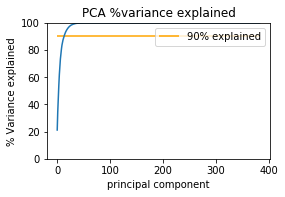

In [126]:
l = get_l(s)
print(l)

In [127]:
print(U.shape)
print(s.shape)
print(V.shape)

(384, 384)
(384,)
(384, 499)


In [128]:
# take the low-rank approximation 
U = U[:,:l]
s = s[:l]
V = V[:l, :]

In [129]:
# compute S'
V = V.conj().T
S_bar = U.T.conj().dot(X2).dot(V) * np.reciprocal(s)

In [130]:
# Find eigenvalues and eigenvectors of S_bar 
w,v = np.linalg.eig(S_bar)

In [131]:
w.shape

(13,)

In [132]:
# Find eigenvalues and eigenvector for A 
A_vec = U.dot(v)
A_eigs = w

In [133]:
# calculate w, the Fourier mode 
# in this case, dt=1
w_Fourier = np.log(A_eigs)

In [134]:
# compute the amplitude coefficients b
b, res, r, sing = np.linalg.lstsq(A_vec, data.T[0], rcond=None)

In [135]:
def plot_w(w_Fourier):
    plt.figure(figsize=(2,2))
    plt.scatter([x.real for x in w_Fourier], [x.imag for x in w_Fourier])
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.title(' Fourier modes')

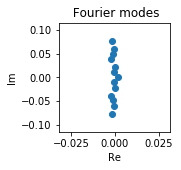

In [136]:
plot_w(w_Fourier)

In [137]:
# choose w_j with larger norms 
w_norm = np.abs(np.imag(w_Fourier))
w_ind = np.argmax(w_norm)

In [138]:
w_ind_list = []
for i in range(3):
    w_ind = np.argmax(w_norm)
    w_ind_list.append(w_ind)
    w_norm[w_ind] = 0 

In [139]:
w_ind_list

[0, 1, 2]

In [140]:
A_vec.shape

(384, 13)

In [141]:
data.shape

(384, 500)

In [142]:
t_list = np.arange(data.shape[1])

In [143]:
back_list = np.zeros((data.shape), dtype=complex)
for i_t, t in enumerate(t_list):
    for w_ind in w_ind_list:
        back = b[w_ind]*A_vec[:,w_ind]*np.exp(w_Fourier[w_ind]*t)
        back_list[:,i_t] += back

In [149]:
len(A_vec[:,0])

384

In [162]:
area_list = np.load('area_list_384.npy')

In [165]:
area_list_unique = []
for area in area_list:
    if area not in area_list_unique:
        area_list_unique.append(area)

In [166]:
len(area_list_unique)

8

In [167]:
area_ind_list = []
for key in area_list_unique: 
    area_ind= [i for i, area in enumerate(area_list) if area==key]
    area_ind_list.append(area_ind)

In [186]:
area_list_unique

["b'CA'",
 "b'VISam'",
 "b'DG'",
 "b'VISp'",
 "b'VISl'",
 "b'none'",
 "b'VISal'",
 "b'VISrl'"]

In [187]:
np.save('area_list_unique', area_list_unique)

In [183]:
area_ind_len

[104, 50, 49, 20, 70, 1, 41, 49]

In [188]:
np.save('area_ind_list', area_ind_list)

In [169]:
len(area_ind_list)

8

In [181]:
area_ind_len = []
for i in range(8):
    area_ind_len.append(len(area_ind_list[i]))

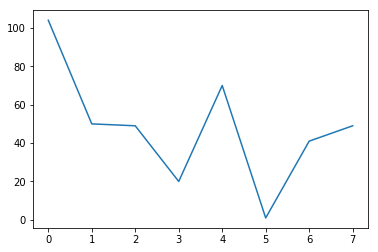

In [182]:
plt.plot(area_ind_len)

Text(0.5,1,'A eigenvector by area, smallest w')

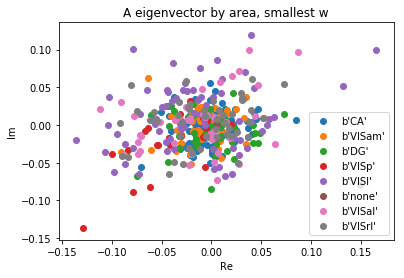

In [180]:
A_ind=np.argmin(w_Fourier)
plt.figure()
for i in range(8):
    key = area_list_unique[i]
    key_ind = area_ind_list[i]
    plt.scatter(np.real(A_vec[key_ind,A_ind]), np.imag(A_vec[key_ind,A_ind]), label=key)
plt.legend()
plt.xlabel('Re')
plt.ylabel('Im')
plt.title('A eigenvector by area, smallest w')

In [144]:
back_list = np.asarray(back_list)
back_list.shape

(384, 500)

Text(0.5,1,'DMD reconstruction with 3 largest Fourier mode')

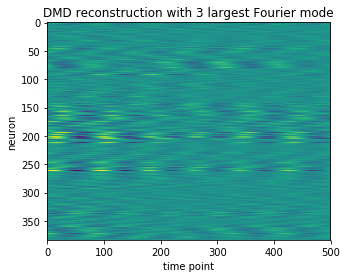

In [158]:
plt.imshow(np.real(back_list))
plt.xlabel('time point')
plt.ylabel('neuron')
plt.title('DMD reconstruction with 3 largest Fourier mode')

Text(0.5,1,'Original data')

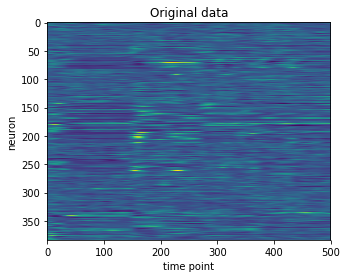

In [159]:
plt.imshow(data)
plt.xlabel('time point')
plt.ylabel('neuron')
plt.title('Original data')